In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

import seaborn as sns
sns.set_style('whitegrid')

/p/software/juwels/stages/2020/software/Jupyter/2021.3.2-gcccoremkl-10.3.0-2021.2.0-Python-3.8.5/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [3]:
def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels

In [4]:
cols = ["P2O5", "K", "Mg", "pH"]

In [5]:
raw_data = '/p/project/hai_cons_ee/data/ai4eo-hyperspectral/raw_data/train_data/'
train_data = os.path.join(raw_data, 'train_data')
test_data = '/p/project/hai_cons_ee/data/ai4eo-hyperspectral/raw_data/test_data/'

X_train = load_data(train_data)
y_train = load_gt(os.path.join(raw_data, "train_gt.csv"))
X_test = load_data(test_data)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (1732, 150)
Test data shape: (1154, 150)


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [7]:
col_ix = [0,1,2,3]

In [8]:
y_train_col = y_train[:, col_ix] # one set of labels only
print(y_train_col.shape)

(1732, 4)


In [9]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train_col, test_size=0.25)

In [10]:
pd.Series(np.mean(X_t, axis=0)).describe()

count     150.000000
mean     1182.394220
std       550.071382
min       375.659938
25%       703.378945
50%      1068.704970
75%      1782.232749
max      1880.267313
dtype: float64

In [11]:
def preprocess(X):
    X /= 1850
    X = X.reshape(len(X), 15, 10).mean(axis=-1)

    dXdl = np.gradient(X, axis=1)
    # d2Xdl2 = np.gradient(dXdl, axis=1)

    # X = np.concatenate((X, dXdl, d2Xdl2), axis=1)
    X = np.concatenate((X, dXdl), axis=1)

    return X

In [12]:
X_t = preprocess(X_t)
X_v = preprocess(X_v)

In [13]:
baseline = BaselineRegressor()
baseline.fit(X_t, y_t)

In [14]:
rf = RandomForestRegressor()

In [15]:
rf.fit(X_t, y_t)

RandomForestRegressor()

In [16]:
rf.score(X_v, y_v)

0.04610711052708549

In [17]:
y_hat = rf.predict(X_v)
y_b = baseline.predict(X_v)

score = 0

for i in range(4):
    print('*'*20, i)
    mse_rf = mean_squared_error(y_v[:, i], y_hat[:, i])
    mse_bl = mean_squared_error(y_v[:, i], y_b[:, i])
    
    score += mse_rf / mse_bl
    
    print(f'Baseline MSE:      {mse_bl:.2f}')
    print(f'Random Forest MSE: {mse_rf:.2f} ({1e2*(mse_rf - mse_bl)/mse_bl:+.2f} %)')

******************** 0
Baseline MSE:      839.58
Random Forest MSE: 845.31 (+0.68 %)
******************** 1
Baseline MSE:      2986.25
Random Forest MSE: 2810.36 (-5.89 %)
******************** 2
Baseline MSE:      1490.51
Random Forest MSE: 1419.25 (-4.78 %)
******************** 3
Baseline MSE:      0.07
Random Forest MSE: 0.06 (-10.25 %)


In [18]:
print('Evaluation score:', score/4)

Evaluation score: 0.9494006711929528


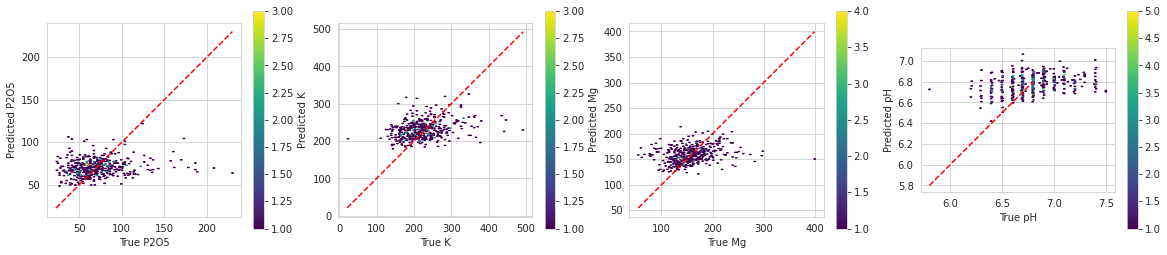

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.set_aspect('equal')

    img=ax.hexbin(y_v[:, i], y_hat[:, i], cmap='viridis', mincnt=1)

    ax.plot(np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])), np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])), 'r--')

    plt.colorbar(img, ax=ax)
    
    ax.set_xlabel('True ' + cols[i])
    ax.set_ylabel('Predicted ' + cols[i])

In [20]:
X_test = preprocess(X_test)

predictions = rf.predict(X_test)


submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")

In [21]:
submission

,P,K,Mg,pH
0,65.604,220.46,151.828,6.7965
1,68.451,229.95,176.684,6.9218
2,66.676,210.03,169.629,6.8820
3,94.787,271.20,186.568,6.8699
4,75.430,212.20,122.658,6.7507
...,...,...,...,...
1149,64.039,210.87,154.346,6.7086
1150,65.862,207.87,153.220,6.6902
1151,63.226,199.82,166.888,6.7811
1152,63.353,224.24,162.518,6.6820
